# Tone Notebook (Parselmouth Edition)

I just copied the other tone_notebook :)

Using answer by Gus B from: https://stackoverflow.com/questions/49264194/import-py-file-in-another-directory-in-jupyter-notebook
Kinda whack but whatever for now. Run the next cell only ONCE (cd..), it changes the working directory to the parent so we can import stuff from the tonami, utils, etc. folder. If you mess up, restart the Jupyter kernel. Run the (cd..) cell again every time you restart.

Parselmouth examples: https://github.com/YannickJadoul/Parselmouth
(next few cells are basically copied from this link)

In [1]:
%cd ..

/app


In [3]:
import warnings
import math
from cmath import log
from random import uniform
from curses import window
from encodings import normalize_encoding
from locale import normalize
from itertools import zip_longest

import parselmouth

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tonami import pitch_process as pp
from dev import utils

warnings.filterwarnings("ignore", message="PySoundFile failed. Trying audioread instead.")

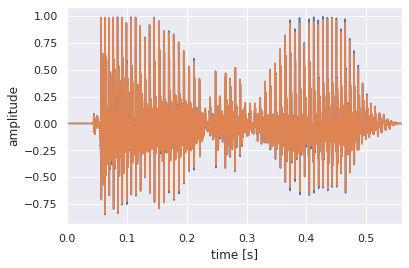

In [10]:
sns.set() # Use seaborn's default style to make attractive graphs

# Plot nice figures using Python's "standard" matplotlib library
test_plot = utils.get_tone_perfect_audiofiles(tone=3, spkr=1, sex='M')
snd = parselmouth.Sound(test_plot[0])
snd1 = parselmouth.Sound(test_plot[1])
plt.figure()
plt.plot(snd.xs(), snd.values.T)
plt.xlim([snd.xmin, snd.xmax])
plt.xlabel("time [s]")
plt.ylabel("amplitude")
plt.show() # or plt.savefig("sound.png"), or plt.savefig("sound.pdf")

/tmp/ipykernel_100/2360300126.py:3: RuntimeWarning: divide by zero encountered in log10
  sg_db = 10 * np.log10(spectrogram.values)
/tmp/ipykernel_100/2360300126.py:4: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.pcolormesh(X, Y, sg_db, vmin=sg_db.max() - dynamic_range, cmap='afmhot')


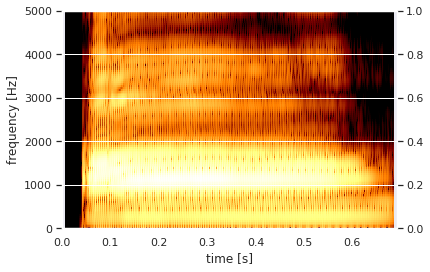

In [6]:
def draw_spectrogram(spectrogram, dynamic_range=70):
    X, Y = spectrogram.x_grid(), spectrogram.y_grid()
    sg_db = 10 * np.log10(spectrogram.values)
    plt.pcolormesh(X, Y, sg_db, vmin=sg_db.max() - dynamic_range, cmap='afmhot')
    plt.ylim([spectrogram.ymin, spectrogram.ymax])
    plt.xlabel("time [s]")
    plt.ylabel("frequency [Hz]")

def draw_intensity(intensity):
    plt.plot(intensity.xs(), intensity.values.T, linewidth=3, color='w')
    plt.plot(intensity.xs(), intensity.values.T, linewidth=1)
    plt.grid(False)
    plt.ylim(0)
    plt.ylabel("intensity [dB]")

intensity = snd.to_intensity()
spectrogram = snd.to_spectrogram()
plt.figure()
draw_spectrogram(spectrogram)
plt.twinx()
draw_intensity(intensity)
plt.xlim([snd.xmin, snd.xmax])
plt.show() # or plt.savefig("spectrogram.pdf")

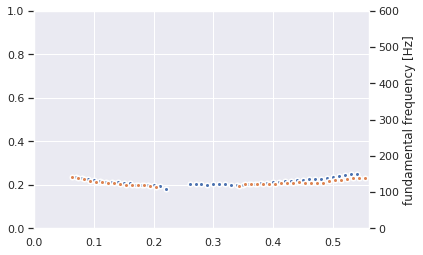

In [11]:
def draw_pitch(pitch):
    # Extract selected pitch contour, and
    # replace unvoiced samples by NaN to not plot
    pitch_values = pitch.selected_array['frequency']
    pitch_values[pitch_values==0] = np.nan
    plt.plot(pitch.xs(), pitch_values, 'o', markersize=5, color='w')
    plt.plot(pitch.xs(), pitch_values, 'o', markersize=2)
    plt.grid(False)
    plt.ylim(0, pitch.ceiling)
    plt.ylabel("fundamental frequency [Hz]")

pitch = snd.to_pitch()
pitch1 = snd1.to_pitch()
# If desired, pre-emphasize the sound fragment before calculating the spectrogram
# pre_emphasized_snd = snd.copy()
# pre_emphasized_snd.pre_emphasize()
# spectrogram = pre_emphasized_snd.to_spectrogram(window_length=0.03, maximum_frequency=8000)
plt.figure()
# draw_spectrogram(spectrogram)
plt.twinx()
draw_pitch(pitch)
draw_pitch(pitch1)
plt.xlim([snd.xmin, snd.xmax])
plt.show() # or plt.savefig("spectrogram_0.03.pdf")

## Tone 1 Analysis

In [4]:
# load audio files for tone 1
def single_speaker_tone(spkr, tone, sex,  samples=10):
    spkr1_t1_files = utils.get_tone_perfect_audiofiles(tone=tone, spkr=spkr, sex=sex)
    tone1 = []

    counter = 0
    for file in spkr1_t1_files:
        y, sr = librosa.load(file)
        f0, voiced_flag, voiced_probs = librosa.pyin(y, fmin=50, fmax=2000)
        if any(x > 1000 for x in f0):
            continue
        if all(math.isnan(x) for x in f0):
            continue
        voiced = pp.get_voice_activity(f0, voiced_flag)
        tone1.append(voiced)
        plt.plot(voiced, label=file)
        
        counter += 1
        if counter == samples:
            break
    if not tone1:
        print("Can't bad")
    # https://stackoverflow.com/questions/52671807/python-multiple-lists-of-different-lengths-averages-and-standard-deviations
    mean_tone1 = np.nanmean(np.array(list(zip_longest(*tone1)),dtype=float),axis=1)

    plt.plot(mean_tone1, '--', label='mean')
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    plt.title(f'Raw {sex}{spkr}V Tone{tone}')
    plt.savefig(f'spkr{sex}{spkr}_t{tone}.png')
    plt.show()  

    plt.figure(1)
    ax = plt.gca()
    ax.set_ylim([0, 5])
    plt.yticks(np.arange(0, 5, 0.5))

    max_f0, min_f0 = pp.max_min_f0(tone1)
    tone1_normalized = []
    for item in tone1:
        smoothed_f0 = pp.moving_average(item)
        normalized_values = pp.normalize_pitch(smoothed_f0, max_f0, min_f0)
        tone1_normalized.append(normalized_values)
        plt.plot(normalized_values)

    mean_tone1_normalized = np.nanmean(np.array(list(zip_longest(*tone1_normalized)),dtype=float),axis=1)
    plt.plot(mean_tone1_normalized, '--', label='mean')
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    plt.title(f'Normalized {sex}{spkr}V Tone{tone}')
    plt.savefig(f'viz_dev/spkr{sex}{spkr}_t{tone}_normalized.png')
    plt.show()



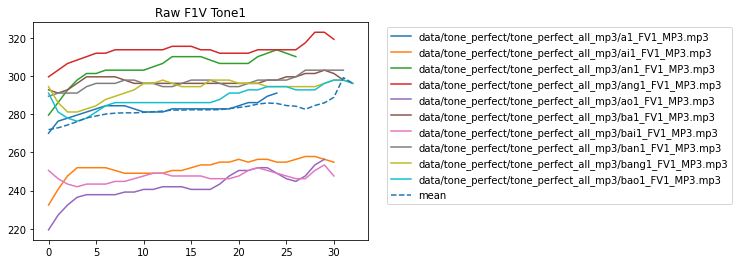

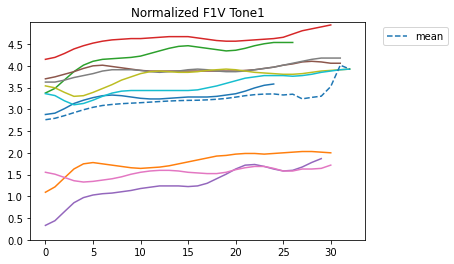

In [5]:
# tone 1
single_speaker_tone(1, 1, 'F')

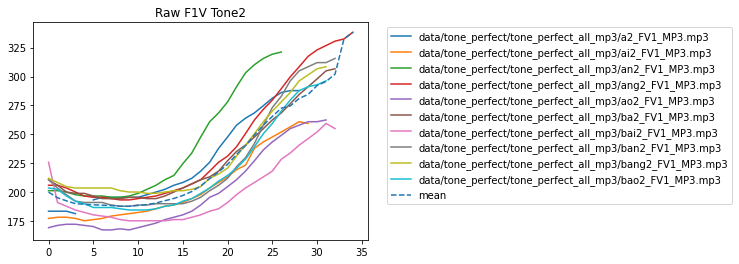

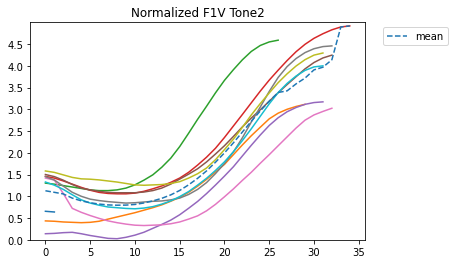

In [6]:
# tone 2
single_speaker_tone(1, 2, 'F')

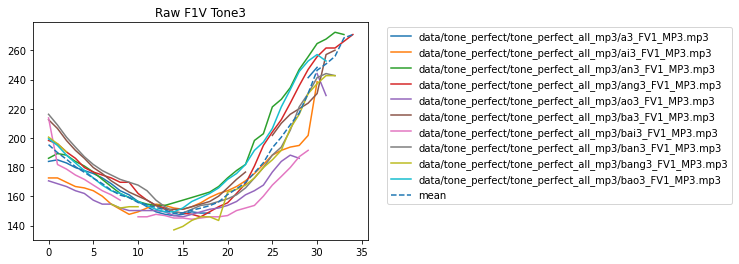

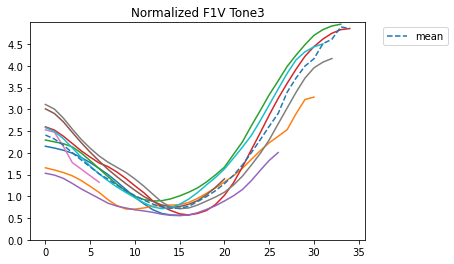

In [5]:
single_speaker_tone(1, 3, 'F')

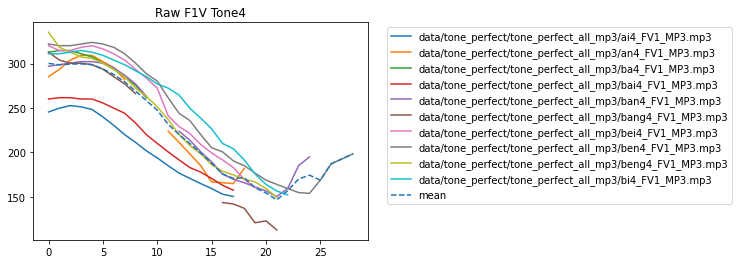

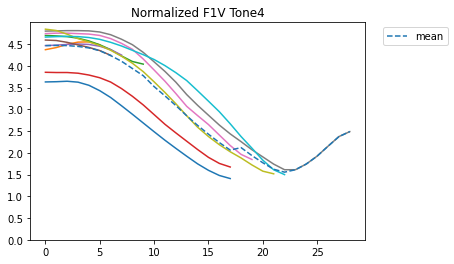

In [6]:
single_speaker_tone(1, 4, 'F')

[         nan 201.15858821 167.21064166 166.24757923 170.13343219
 175.11872228 176.13317472 174.11011266 170.13343219 163.39154532
 154.22108254 147.25670581 139.79699342 134.25725028 124.54496224
 121.70035137 120.30250361 109.05077327 106.56005016 111.59971426
 137.39536475          nan          nan 140.60682916 135.81724438
 138.191288  ]
[0.17653061 0.01000002 0.17653061 0.2065068  0.03489743 0.54852505
 0.98487898 0.48498681 0.12793709 0.01082446 0.01025905 0.01003777
 0.01240312 0.01000618 0.01062261 0.1504646  0.04768699 0.01818738
 0.01000123 0.01000002 0.01002672 0.01000003 0.01       0.01007375
 0.02616803 0.09203757]


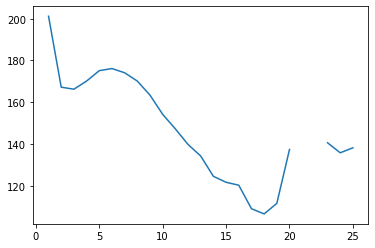

In [60]:
# WEIRD BEHAVIOUR
weird_audio = 'data/tone_perfect/tone_perfect_all_mp3/ai4_MV2_MP3.mp3'
y, sr = librosa.load(weird_audio)
f0, voiced_flag, voiced_probs = librosa.pyin(y, fmin=50, fmax=2000)
print(f0)
print(voiced_probs)
plt.plot(f0, label=weird_audio)
# plt.savefig('anomaly_a4_MV3.png')
plt.show()

In [51]:
print(librosa.note_to_hz('C2')) 
print(librosa.note_to_hz('C7'))

65.40639132514966
2093.004522404789


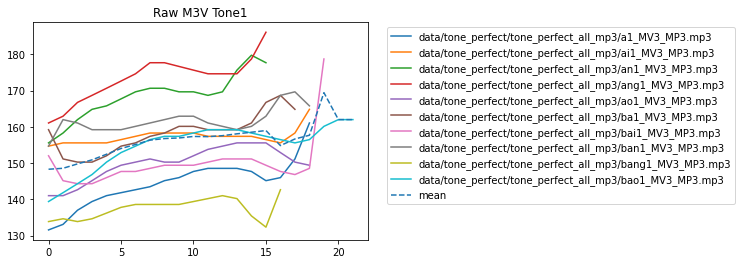

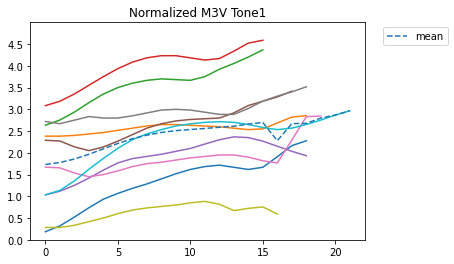

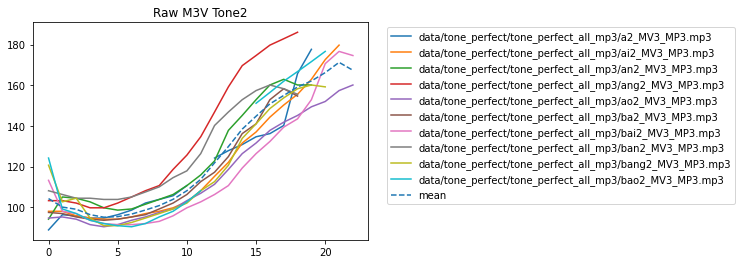

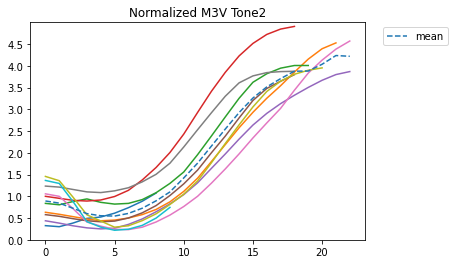

IndexError: index 14 is out of bounds for axis 0 with size 14

In [10]:
single_speaker_tone(3, 1, 'M')
single_speaker_tone(3, 2, 'M')
# single_speaker_tone(3, 3, 'M')

In [45]:
single_speaker_tone(1, 4, 'M')

[]


AxisError: axis 1 is out of bounds for array of dimension 1

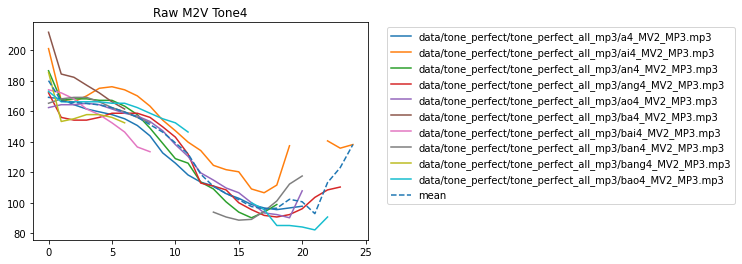

/tmp/ipykernel_4461/1693287038.py:46: RuntimeWarning: Mean of empty slice
  mean_tone1_normalized = np.nanmean(np.array(list(zip_longest(*tone1_normalized)),dtype=float),axis=1)


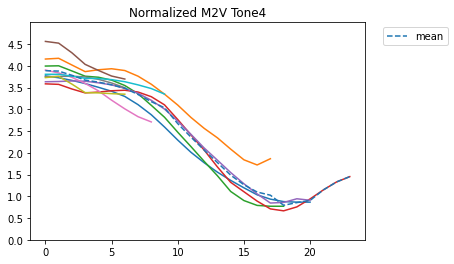

In [67]:
single_speaker_tone(2, 4, 'M')


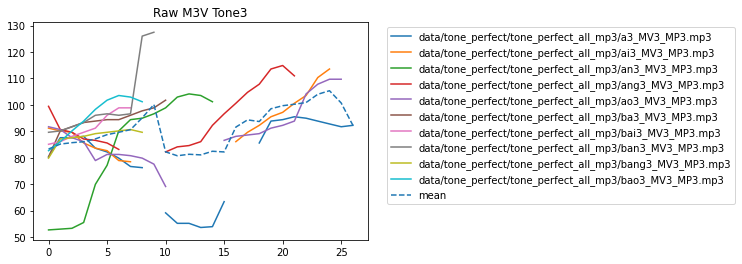

/tmp/ipykernel_4461/1693287038.py:46: RuntimeWarning: Mean of empty slice
  mean_tone1_normalized = np.nanmean(np.array(list(zip_longest(*tone1_normalized)),dtype=float),axis=1)


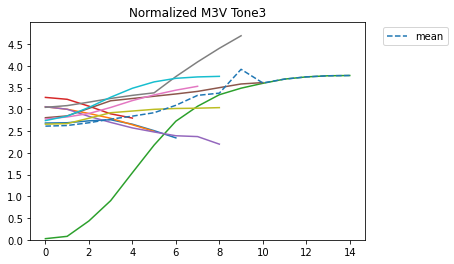

In [69]:
single_speaker_tone(3, 3, 'M')